In [22]:
from parsel import Selector
from playwright.sync_api import sync_playwright
import json
import time
import pandas as pd

In [23]:
df = pd.read_csv("responseAPI.csv")
df.head()

,title,link,source_link,publication_type,publication_date,publication_doi,authors
0,Gbd 2019 Tuberculosis,https://www.researchgate.netpublication/354977...,https://www.researchgate.netNone,Article,Sep 2021,ISBN: 1473-3099,"['GBD 2019 Tuberculosis Collaborators', 'Narin..."
1,Tuberculosis,https://www.researchgate.netpublication/373742...,https://www.researchgate.netNone,Chapter,Sep 2023,DOI: 10.1007/978-3-031-33851-9_12,"['Simone Villa', 'Giovanni Battista Migliori',..."
2,Drug Resistant Tuberculosis,https://www.researchgate.netpublication/336146...,https://www.researchgate.netpublication/336146...,Article,Jan 2019,DOI: 10.15584/ejcem.2019.3.11,"['Balaji Zacharia', 'Antony Roy', 'Multi Drug'..."
3,Treatment Guidelines For Latent Tuberculosis I...,https://www.researchgate.netpublication/292253...,https://www.researchgate.netNone,Article,Jan 2014,ISBN: 0022-9776,['Prevention Committee of the Japanese Society...
4,Non-Mycobacteria Tuberculosis… Non-Mycobacteri...,https://www.researchgate.netpublication/373389...,https://www.researchgate.netpublication/373389...,Article,Sep 2023,DOI: 10.4314/ejhs.v33i5.21,"['Olufemi Ojo', 'Abiona Odeyemi']"


In [24]:
# Import Dataset
papers = df[['title']]
print(papers.shape)  #> (2361, 3)
papers.head()

(520, 1)


,title
0,Gbd 2019 Tuberculosis
1,Tuberculosis
2,Drug Resistant Tuberculosis
3,Treatment Guidelines For Latent Tuberculosis I...
4,Non-Mycobacteria Tuberculosis… Non-Mycobacteri...


In [25]:
# Load the regular expression library
import re
# Remove punctuation
papers = papers.astype(str)
papers['paper_text_processed'] = \
papers['title'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

0                                gbd 2019 tuberculosis
1                                         tuberculosis
2                          drug resistant tuberculosis
3    treatment guidelines for latent tuberculosis i...
4    non-mycobacteria tuberculosis… non-mycobacteri...
Name: paper_text_processed, dtype: object

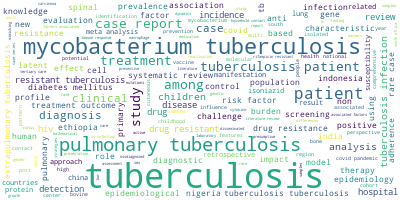

In [26]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [27]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['patient', 'treatmen', 're', 'edu', 'use', 'using', 'disease', 'case', 'clinical', 'tb', 'patients', 'study', 'health', 'factors', 'risk', 'infection', 'tuberculosis', 'used' ,'diseases', 'care' ,'associated' ,'time' ,'drug ','showed'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['gbd']


[nltk_data] Downloading package stopwords to C:\Users\dalob.DESKTOP-
[nltk_data]     HKFUG9V\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1)]


In [29]:
from pprint import pprint  
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.037*"mycobacterium" + 0.017*"resistant" + 0.017*"drug" + '
  '0.015*"pulmonary" + 0.012*"review" + 0.010*"diagnosis" + 0.007*"incidence" '
  '+ 0.007*"detection" + 0.007*"new" + 0.007*"children"'),
 (1,
  '0.037*"mycobacterium" + 0.019*"treatment" + 0.009*"human" + '
  '0.009*"pulmonary" + 0.009*"drug" + 0.008*"analysis" + 0.006*"hospital" + '
  '0.005*"anti" + 0.005*"spinal" + 0.005*"epcp"'),
 (2,
  '0.022*"mycobacterium" + 0.013*"pulmonary" + 0.011*"report" + '
  '0.009*"diagnosis" + 0.007*"based" + 0.007*"western" + 0.007*"among" + '
  '0.007*"treatment" + 0.006*"new" + 0.006*"hospital"'),
 (3,
  '0.014*"review" + 0.013*"human" + 0.012*"mycobacterium" + 0.011*"systematic" '
  '+ 0.011*"analysis" + 0.009*"meta" + 0.009*"india" + 0.008*"treatment" + '
  '0.008*"ethiopia" + 0.007*"children"'),
 (4,
  '0.013*"treatment" + 0.008*"pulmonary" + 0.008*"mycobacterium" + '
  '0.008*"rate" + 0.008*"de" + 0.005*"clinico" + 0.005*"rifampicin" + '
  '0.005*"based" + 0.005*"population" +

In [30]:
df.drop(['link', 'source_link'], axis=1, inplace=True)
df.head()

,title,publication_type,publication_date,publication_doi,authors
0,Gbd 2019 Tuberculosis,Article,Sep 2021,ISBN: 1473-3099,"['GBD 2019 Tuberculosis Collaborators', 'Narin..."
1,Tuberculosis,Chapter,Sep 2023,DOI: 10.1007/978-3-031-33851-9_12,"['Simone Villa', 'Giovanni Battista Migliori',..."
2,Drug Resistant Tuberculosis,Article,Jan 2019,DOI: 10.15584/ejcem.2019.3.11,"['Balaji Zacharia', 'Antony Roy', 'Multi Drug'..."
3,Treatment Guidelines For Latent Tuberculosis I...,Article,Jan 2014,ISBN: 0022-9776,['Prevention Committee of the Japanese Society...
4,Non-Mycobacteria Tuberculosis… Non-Mycobacteri...,Article,Sep 2023,DOI: 10.4314/ejhs.v33i5.21,"['Olufemi Ojo', 'Abiona Odeyemi']"


In [31]:
topic_numDB = []
topic_probDB = []


for doc_topics in doc_lda:
    # Ordenar las asignaciones de tópicos por probabilidad
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    
    # Tomar el tópico más relevante (el que tiene la probabilidad más alta)
    main_topic = doc_topics[0]
    
    # Extraer el número de tópico y su probabilidad
    topic_num, topic_prob = main_topic
    
    # Agregar estos datos a la lista
    topic_numDB.append(topic_num)
    topic_probDB.append(topic_prob)


df['Topic Number'] = topic_numDB
df['Topic Probability'] = topic_probDB

df.head(100)

,title,publication_type,publication_date,publication_doi,authors,Topic Number,Topic Probability
0,Gbd 2019 Tuberculosis,Article,Sep 2021,ISBN: 1473-3099,"['GBD 2019 Tuberculosis Collaborators', 'Narin...",8,0.549955
1,Tuberculosis,Chapter,Sep 2023,DOI: 10.1007/978-3-031-33851-9_12,"['Simone Villa', 'Giovanni Battista Migliori',...",0,0.100000
2,Drug Resistant Tuberculosis,Article,Jan 2019,DOI: 10.15584/ejcem.2019.3.11,"['Balaji Zacharia', 'Antony Roy', 'Multi Drug'...",0,0.699968
3,Treatment Guidelines For Latent Tuberculosis I...,Article,Jan 2014,ISBN: 0022-9776,['Prevention Committee of the Japanese Society...,5,0.774948
4,Non-Mycobacteria Tuberculosis… Non-Mycobacteri...,Article,Sep 2023,DOI: 10.4314/ejhs.v33i5.21,"['Olufemi Ojo', 'Abiona Odeyemi']",8,0.887484
...,...,...,...,...,...,...,...
95,#1039 Extrapulmonary Tuberculosis Mimicking Ov...,Conference Paper,Sep 2023,DOI: 10.1136/ijgc-2023-ESGO.483,"['Vlatko Gjirevski', 'Marjan Stojovski', 'Vikt...",3,0.871410
96,"Tuberculosis: Insights Into Latency, Treatment...",Article,Aug 2023,DOI: 10.3389/ftubr.2023.1230713,['Harald G. Wiker'],7,0.887484
97,Assessment Of Lipid Profile On Patients With P...,Article,Aug 2023,DOI: 10.31080/ASMS.2023.07.1645,"['Airhomwanbor KO', 'Kenneth OSHIOKHAYAMHE Iye...",7,0.819959
98,Cost-Effectiveness And Budget Impact Of Decent...,Preprint,Sep 2023,DOI: 10.1101/2023.09.26.23295962,"['Marc d’Elbée', 'Martin Harker', 'Nyashadzais...",0,0.935702


In [33]:
df.to_csv('tfm_eoi_tecnologico_ExplotacionDatosResearchGates.csv', index=False)